In [4]:
!wget https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv

--2022-05-02 14:46:42--  https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86845 (85K) [text/plain]
Saving to: ‘example_wp_log_peyton_manning.csv’

example_wp_log_peyt 100%[===================>]  84.81K  --.-KB/s    in 0.04s   

2022-05-02 14:46:42 (1.85 MB/s) - ‘example_wp_log_peyton_manning.csv’ saved [86845/86845]



In [111]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import GPy
from GPy import kern

from sklearn.metrics import mean_squared_error

In [87]:
df = pd.read_csv('./example_wp_log_peyton_manning.csv', parse_dates=['ds'])
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2905 non-null   datetime64[ns]
 1   y       2905 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 45.5 KB


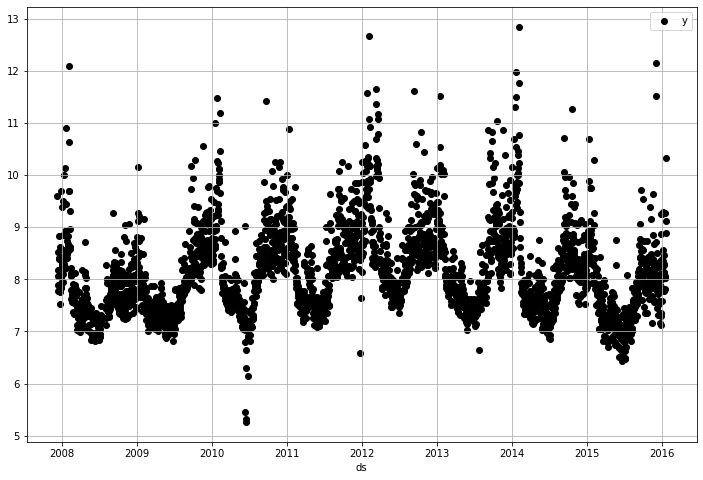

In [89]:
plt.figure(figsize=(12, 8))
plt.scatter(df['ds'], df['y'], color='k', label='y')
plt.xlabel('ds')
plt.grid()
plt.legend()
plt.show()

- 1年の変動が毎年大体同じ（年次の周期性がある可能性）

## 試しに計算してみる

In [90]:
# 2015年以降をテストデータ，それ以外を学習データとする
df['is_train'] = df['ds'] < pd.to_datetime('2015-01-01')

In [91]:
# ガウス過程は目的変数の平均０を仮定しているようなので，標準化する
df['y'] = (df['y'] - df['y'].mean()) / df['y'].std()

In [92]:
df.head()

,ds,y,is_train
0,2007-12-10,1.716167,True
1,2007-12-11,0.449943,True
2,2007-12-12,0.052862,True
3,2007-12-13,-0.078598,True
4,2007-12-14,-0.290069,True


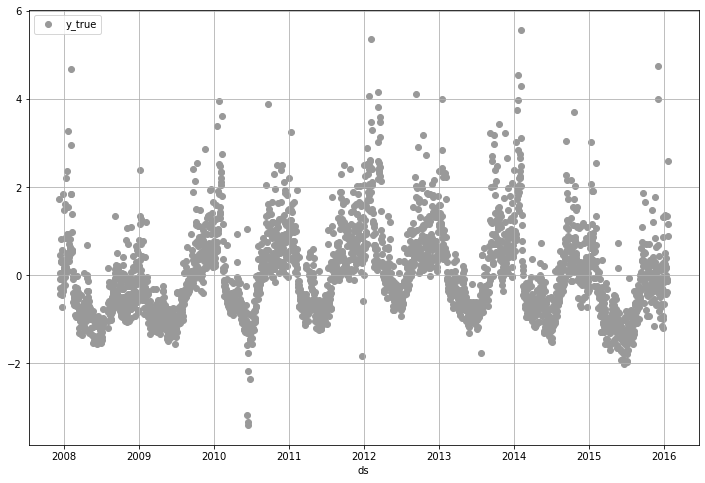

In [110]:
plt.figure(figsize=(12, 8))
plt.scatter(df['ds'], df['y'], color='#999999', label='y_true')
plt.xlabel('ds')
plt.grid()
plt.legend(loc='upper left')
plt.show()

In [94]:
kernel = kern.RBF(input_dim=1) + kern.Bias(input_dim=1)


m = GPy.models.GPRegression(
    X=np.arange(len(df.loc[df['is_train']==True]))[:, None],
    Y=df.loc[df['is_train']==True, 'y'].values[:, None],
    normalizer=None
)

In [95]:
yhat, yhat_var = m.predict(
    np.arange(len(df))[:, None]
)
yhat_std = yhat_var ** .5

In [96]:
yhat.shape

(2905, 1)

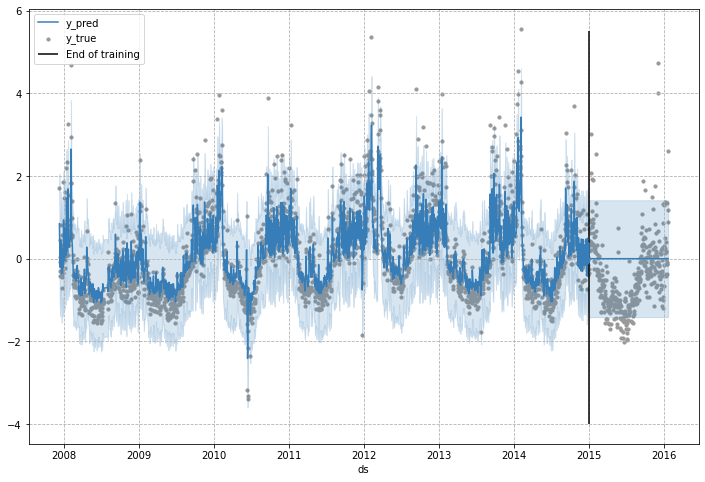

In [97]:
plt.figure(figsize=(12, 8))
plt.scatter(df['ds'], df['y'], color='#999999', label='y_true', s=10)
plt.plot(df['ds'], yhat, label='y_pred', color='#377eb8')
plt.fill_between(
    df['ds'],
    yhat.reshape(-1) - yhat_std.reshape(-1),
    yhat.reshape(-1) + yhat_std.reshape(-1),
    color='#377eb8',
    alpha=.2
)
plt.vlines(pd.to_datetime('2014-12-31'), -4, 5.5, label='End of training', color='k')
plt.xlabel('ds')
plt.grid(linestyle='--')
plt.legend()
plt.show()

## 特徴量をフーリエ級数にして計算してみる

In [98]:
def add_fourier(df: pd.DataFrame, period: float, order: int) -> pd.DataFrame:
    df[f'fourier_O{order}_sin'] = np.sin(2 * np.pi * order * np.arange(len(df)) / period)
    df[f'fourier_O{order}_cos'] = np.cos(2 * np.pi * order * np.arange(len(df)) / period)
    return df

In [99]:
for i in range(10):
    df = add_fourier(df, period=365.25, order=i+1)

In [100]:
df.head()

,ds,y,is_train,fourier_O1_sin,fourier_O1_cos,fourier_O2_sin,fourier_O2_cos,fourier_O3_sin,fourier_O3_cos,fourier_O4_sin,...,fourier_O6_sin,fourier_O6_cos,fourier_O7_sin,fourier_O7_cos,fourier_O8_sin,fourier_O8_cos,fourier_O9_sin,fourier_O9_cos,fourier_O10_sin,fourier_O10_cos
0,2007-12-10,1.716167,True,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,2007-12-11,0.449943,True,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669,0.068755,...,0.103031,0.994678,0.120126,0.992759,0.137185,0.990545,0.154204,0.988039,0.171177,0.985240
2,2007-12-12,0.052862,True,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678,0.137185,...,0.204966,0.978769,0.238513,0.971139,0.271777,0.962360,0.304719,0.952442,0.337301,0.941397
3,2007-12-13,-0.078598,True,0.051584,0.998669,0.103031,0.994678,0.154204,0.988039,0.204966,...,0.304719,0.952442,0.353445,0.935455,0.401229,0.915978,0.447945,0.894061,0.493468,0.869764
4,2007-12-14,-0.290069,True,0.068755,0.997634,0.137185,0.990545,0.204966,0.978769,0.271777,...,0.401229,0.915978,0.463258,0.886224,0.523094,0.852275,0.580455,0.814292,0.635068,0.772456


In [101]:
x_columns = [c for c in df.columns.tolist() if 'fourier' in c]

In [102]:
kernel = kern.RBF(input_dim=20) + kern.Bias(input_dim=20)


m = GPy.models.GPRegression(
    X=df.loc[df['is_train']==True, x_columns].values,
    Y=df.loc[df['is_train']==True, 'y'].values[:, None],
    normalizer=None
)

In [103]:
yhat, yhat_var = m.predict(df.loc[:, x_columns].values)
yhat_std = yhat_var ** .5

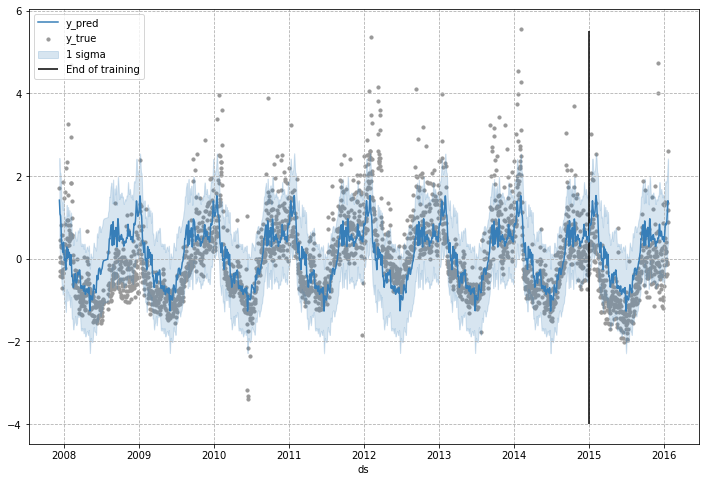

In [109]:
plt.figure(figsize=(12, 8))
plt.scatter(df['ds'], df['y'], color='#999999', label='y_true', s=10)
plt.plot(df['ds'], yhat, label='y_pred', color='#377eb8')
plt.fill_between(
    df['ds'],
    yhat.reshape(-1) - yhat_std.reshape(-1),
    yhat.reshape(-1) + yhat_std.reshape(-1),
    color='#377eb8',
    alpha=.2,
    label='1 sigma'
)
plt.vlines(pd.to_datetime('2014-12-31'), -4, 5.5, label='End of training', color='k')
plt.xlabel('ds')
plt.grid(linestyle='--')
plt.legend(loc='upper left')
plt.show()

In [114]:
rmse = mean_squared_error(
    y_true=df.loc[df['is_train']==False, 'y'].values
    , y_pred=yhat[-len(df.loc[df['is_train']==False]):]
    , squared=False
)
print(f'rmse: {rmse}')

rmse: 0.8330597965448284


## 比較対象として，prophetも学習してみる

In [115]:
from prophet import Prophet

In [124]:
# 今回のガウス過程のモデルにトレンドを表現する工夫は施していないので，prophetからも外す
m = Prophet(growth='flat')
m.fit(df.loc[df['is_train']==True, ['ds', 'y']])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -42.5848
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      12       4001.39   5.61769e-05      0.034222           1           1       18   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [125]:
df_pred = m.predict(df)

In [126]:
df_pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-12-10,0.058253,0.057428,1.858076,0.058253,0.058253,0.911531,0.911531,0.911531,0.411051,0.411051,0.411051,0.500480,0.500480,0.500480,0.0,0.0,0.0,0.969784
1,2007-12-11,0.058253,-0.151181,1.567010,0.058253,0.058253,0.617592,0.617592,0.617592,0.134005,0.134005,0.134005,0.483587,0.483587,0.483587,0.0,0.0,0.0,0.675845
2,2007-12-12,0.058253,-0.401032,1.416993,0.058253,0.058253,0.379298,0.379298,0.379298,-0.088347,-0.088347,-0.088347,0.467645,0.467645,0.467645,0.0,0.0,0.0,0.437551
3,2007-12-13,0.058253,-0.452615,1.279727,0.058253,0.058253,0.356927,0.356927,0.356927,-0.096189,-0.096189,-0.096189,0.453116,0.453116,0.453116,0.0,0.0,0.0,0.415180
4,2007-12-14,0.058253,-0.499456,1.363972,0.058253,0.058253,0.347736,0.347736,0.347736,-0.092686,-0.092686,-0.092686,0.440422,0.440422,0.440422,0.0,0.0,0.0,0.405989


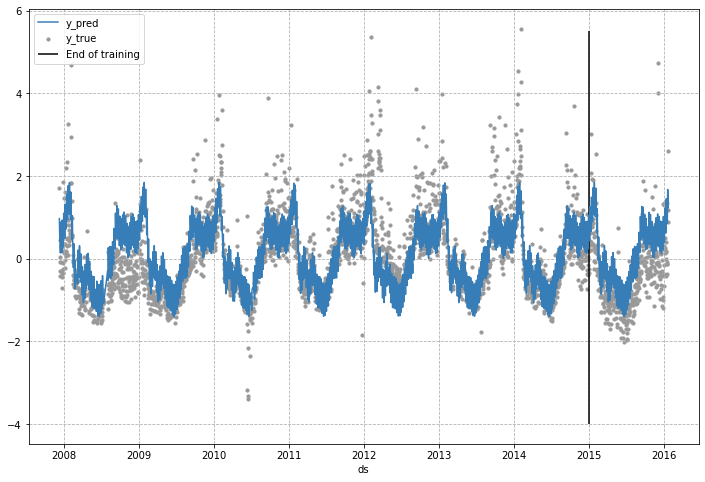

In [127]:
plt.figure(figsize=(12, 8))
plt.scatter(df['ds'], df['y'], color='#999999', label='y_true', s=10)
plt.plot(df_pred['ds'], df_pred['yhat'], label='y_pred', color='#377eb8')
plt.vlines(pd.to_datetime('2014-12-31'), -4, 5.5, label='End of training', color='k')
plt.xlabel('ds')
plt.grid(linestyle='--')
plt.legend(loc='upper left')
plt.show()

In [128]:
rmse = mean_squared_error(
    y_true=df.loc[df['is_train']==False, 'y'].values
    , y_pred=df_pred.loc[df_pred['ds']>=pd.to_datetime('2015-01-01'), 'yhat']
    , squared=False
)
print(f'rmse: {rmse}')

rmse: 0.7730591333169432
